In [1]:
import warnings

import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

# Import plotting modules and set up
import seaborn as sns

sns.set()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_context(
    "notebook", font_scale=1.5, rc={"figure.figsize": (11, 8), "axes.titlesize": 18}
)

from matplotlib import rcParams

rcParams["figure.figsize"] = 11, 8

## Часть 1. Предварительные анализ данных.


In [2]:
df = pd.read_csv("data/mlbootcamp5_train.csv", sep=';')
print(f"Dataset size: {df.shape}")
df.head()

Dataset size: (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


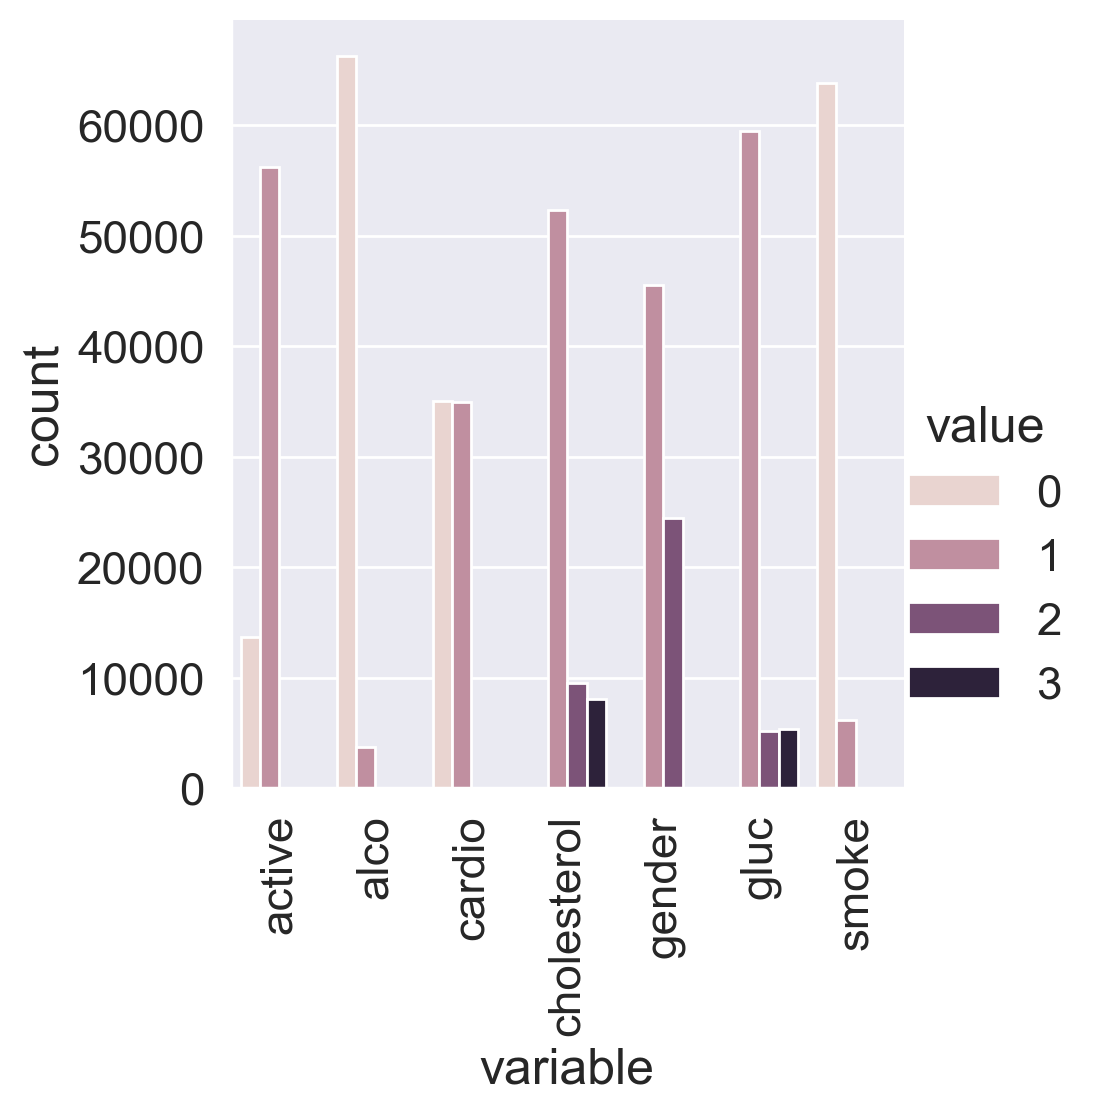

In [3]:
df_uniques = pd.melt(
    frame=df,
    value_vars=["gender", "cholesterol", "gluc", "smoke", "alco", "active", "cardio"],
)
df_uniques = (
    pd.DataFrame(df_uniques.groupby(["variable", "value"])["value"].count())
    .sort_index(level=[0, 1])
    .rename(columns={"value": "count"})
    .reset_index()
)

sns.catplot(
    x="variable", y="count", hue="value", data=df_uniques, kind="bar"
)
plt.xticks(rotation='vertical');

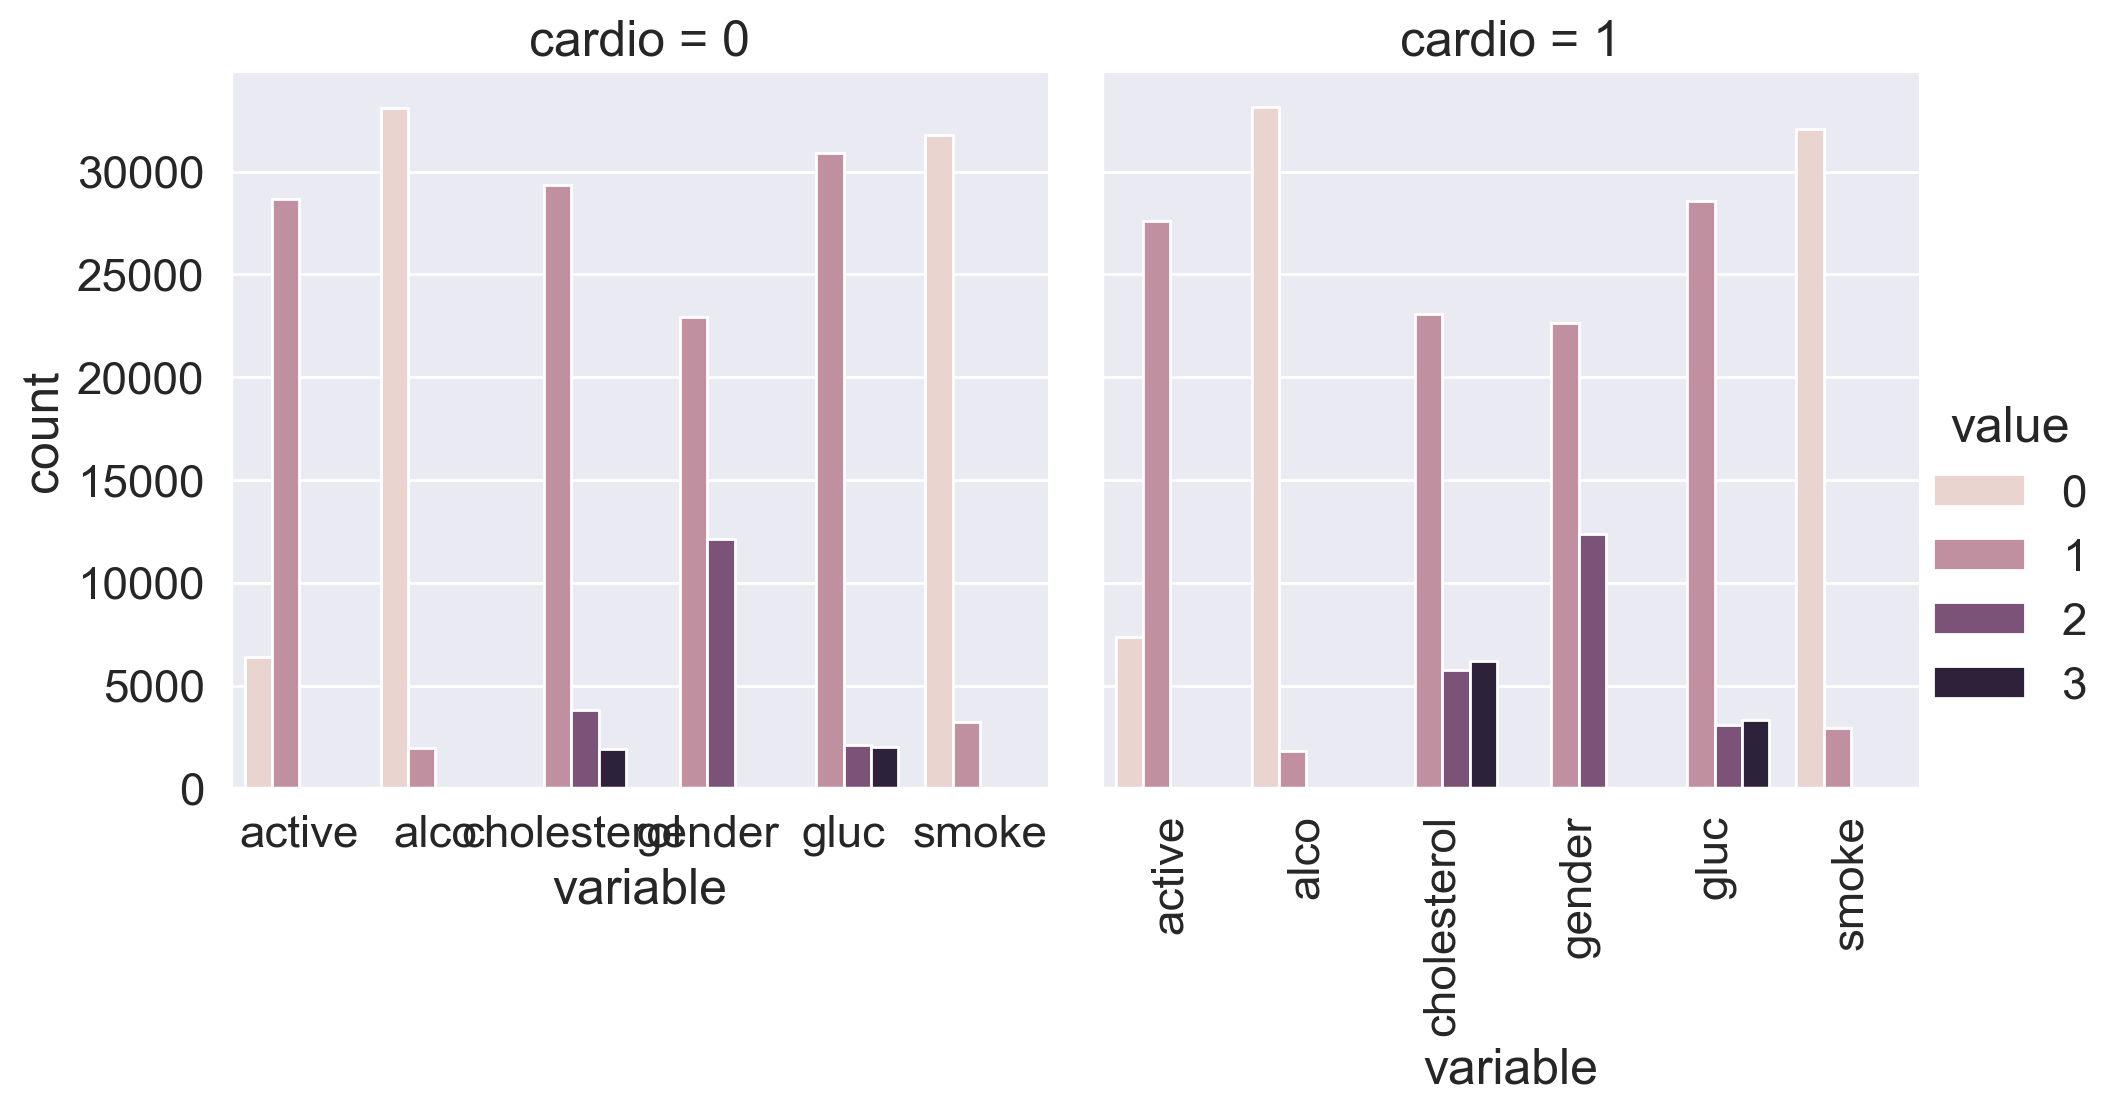

In [4]:


df_uniques = pd.melt(
    frame=df,
    value_vars=["gender", "cholesterol", "gluc", "smoke", "alco", "active"],
    id_vars=["cardio"],
)
df_uniques = (
    pd.DataFrame(df_uniques.groupby(["variable", "value", "cardio"])["value"].count())
    .sort_index(level=[0, 1])
    .rename(columns={"value": "count"})
    .reset_index()
)
sns.catplot(
    x="variable",
    y="count",
    hue="value",
    col="cardio",
    data=df_uniques,
    kind="bar"
)
plt.xticks(rotation='vertical');

In [5]:
for c in df.columns:
    n = df[c].nunique()
    print(c)
    if n <= 3:
        print(n, sorted(df[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10 * "-")

id
70000
----------
age
8076
----------
gender
2 [(1, 45530), (2, 24470)]
----------
height
109
----------
weight
287
----------
ap_hi
153
----------
ap_lo
157
----------
cholesterol
3 [(1, 52385), (2, 9549), (3, 8066)]
----------
gluc
3 [(1, 59479), (2, 5190), (3, 5331)]
----------
smoke
2 [(0, 63831), (1, 6169)]
----------
alco
2 [(0, 66236), (1, 3764)]
----------
active
2 [(0, 13739), (1, 56261)]
----------
cardio
2 [(0, 35021), (1, 34979)]
----------


#### 1.1. Основные наблюдения.

In [6]:
# 1.1.
display(df.groupby('gender')["height"].mean())
df['gender'].value_counts()
# 1

gender
1    161.355612
2    169.947895
Name: height, dtype: float64

gender
1    45530
2    24470
Name: count, dtype: int64

In [7]:
df['gender_name'] = df['gender'].map({2: "Men", 1: "Women"})

In [8]:
# 1.2.
display(df.groupby('gender_name')['alco'].mean())
# 2

gender_name
Men      0.106375
Women    0.025500
Name: alco, dtype: float64

In [9]:
# 1.3. 
display(df.groupby("gender")["smoke"].mean())
round(
    100 * (df.loc[df["gender"] == 2, "smoke"].mean() - df.loc[df["gender"] == 1, "smoke"].mean())
)
# 3

gender
1    0.017856
2    0.218880
Name: smoke, dtype: float64

20

In [10]:
# 1.4.
df.groupby("smoke")["age"].median() / 365.25
(
    df[df["smoke"] == 0]["age"].median() - df[df["smoke"] == 1]["age"].median()
) / 365.25 * 12
# 4

19.613963039014372

#### 1.2 Risk maps


In [11]:
df["age_years"] = (df["age"] / 365.25).round().astype("int")
df["age_years"].max()

65

In [12]:
smoking_old_men = df[
    (df["gender"] == 2)
    & (df["age_years"] >= 60)
    & (df["age_years"] < 65)
    & (df["smoke"] == 1)
]

In [13]:
smoking_old_men[
    (smoking_old_men["cholesterol"] == 3)
    & (smoking_old_men["ap_hi"] >= 160)
    & (smoking_old_men["ap_hi"] < 180)
]["cardio"].mean() / smoking_old_men[
    (smoking_old_men["cholesterol"] == 1) & (smoking_old_men["ap_hi"] < 120)
]["cardio"].mean()

3.281818181818182

 #### 1.3. Analyzing BMI

In [14]:
df['BMI'] = df['weight'] / (df['height'] / 100) ** 2
# 1.6
# 1
print(df['BMI'].median()) # NO
# 2 
display(df.groupby('gender_name')['BMI'].mean()) # YES
# 3
display(df.groupby('cardio')['BMI'].mean()) # NO
# 4 
df.groupby(["gender_name", "alco", "cardio"])["BMI"].median().to_frame() # YES

26.374068120774975


gender_name
Men      26.754442
Women    27.987583
Name: BMI, dtype: float64

cardio
0    26.548175
1    28.566061
Name: BMI, dtype: float64

BMI
gender_name alco cardio           
Men         0    0       25.102391
                 1       26.674874
            1    0       25.351541
                 1       27.530797
Women       0    0       25.654372
                 1       27.885187
            1    0       27.885187
                 1       30.110991

#### 1.4. Cleaning data

In [15]:
df_to_remove = df[
    (df["ap_lo"] > df["ap_hi"])
    | (df["height"] < df["height"].quantile(0.025))
    | (df["height"] > df["height"].quantile(0.975))
    | (df["weight"] < df["weight"].quantile(0.025))
    | (df["weight"] > df["weight"].quantile(0.975))
]
print(df_to_remove.shape[0] / df.shape[0])

df = df.drop(['gender_name'],axis=1)
filtered_df = df[~df.index.isin(df_to_remove)]


0.0963


## Часть 2. Visual data analysis

#### 2.1. Correlation matrix visualization

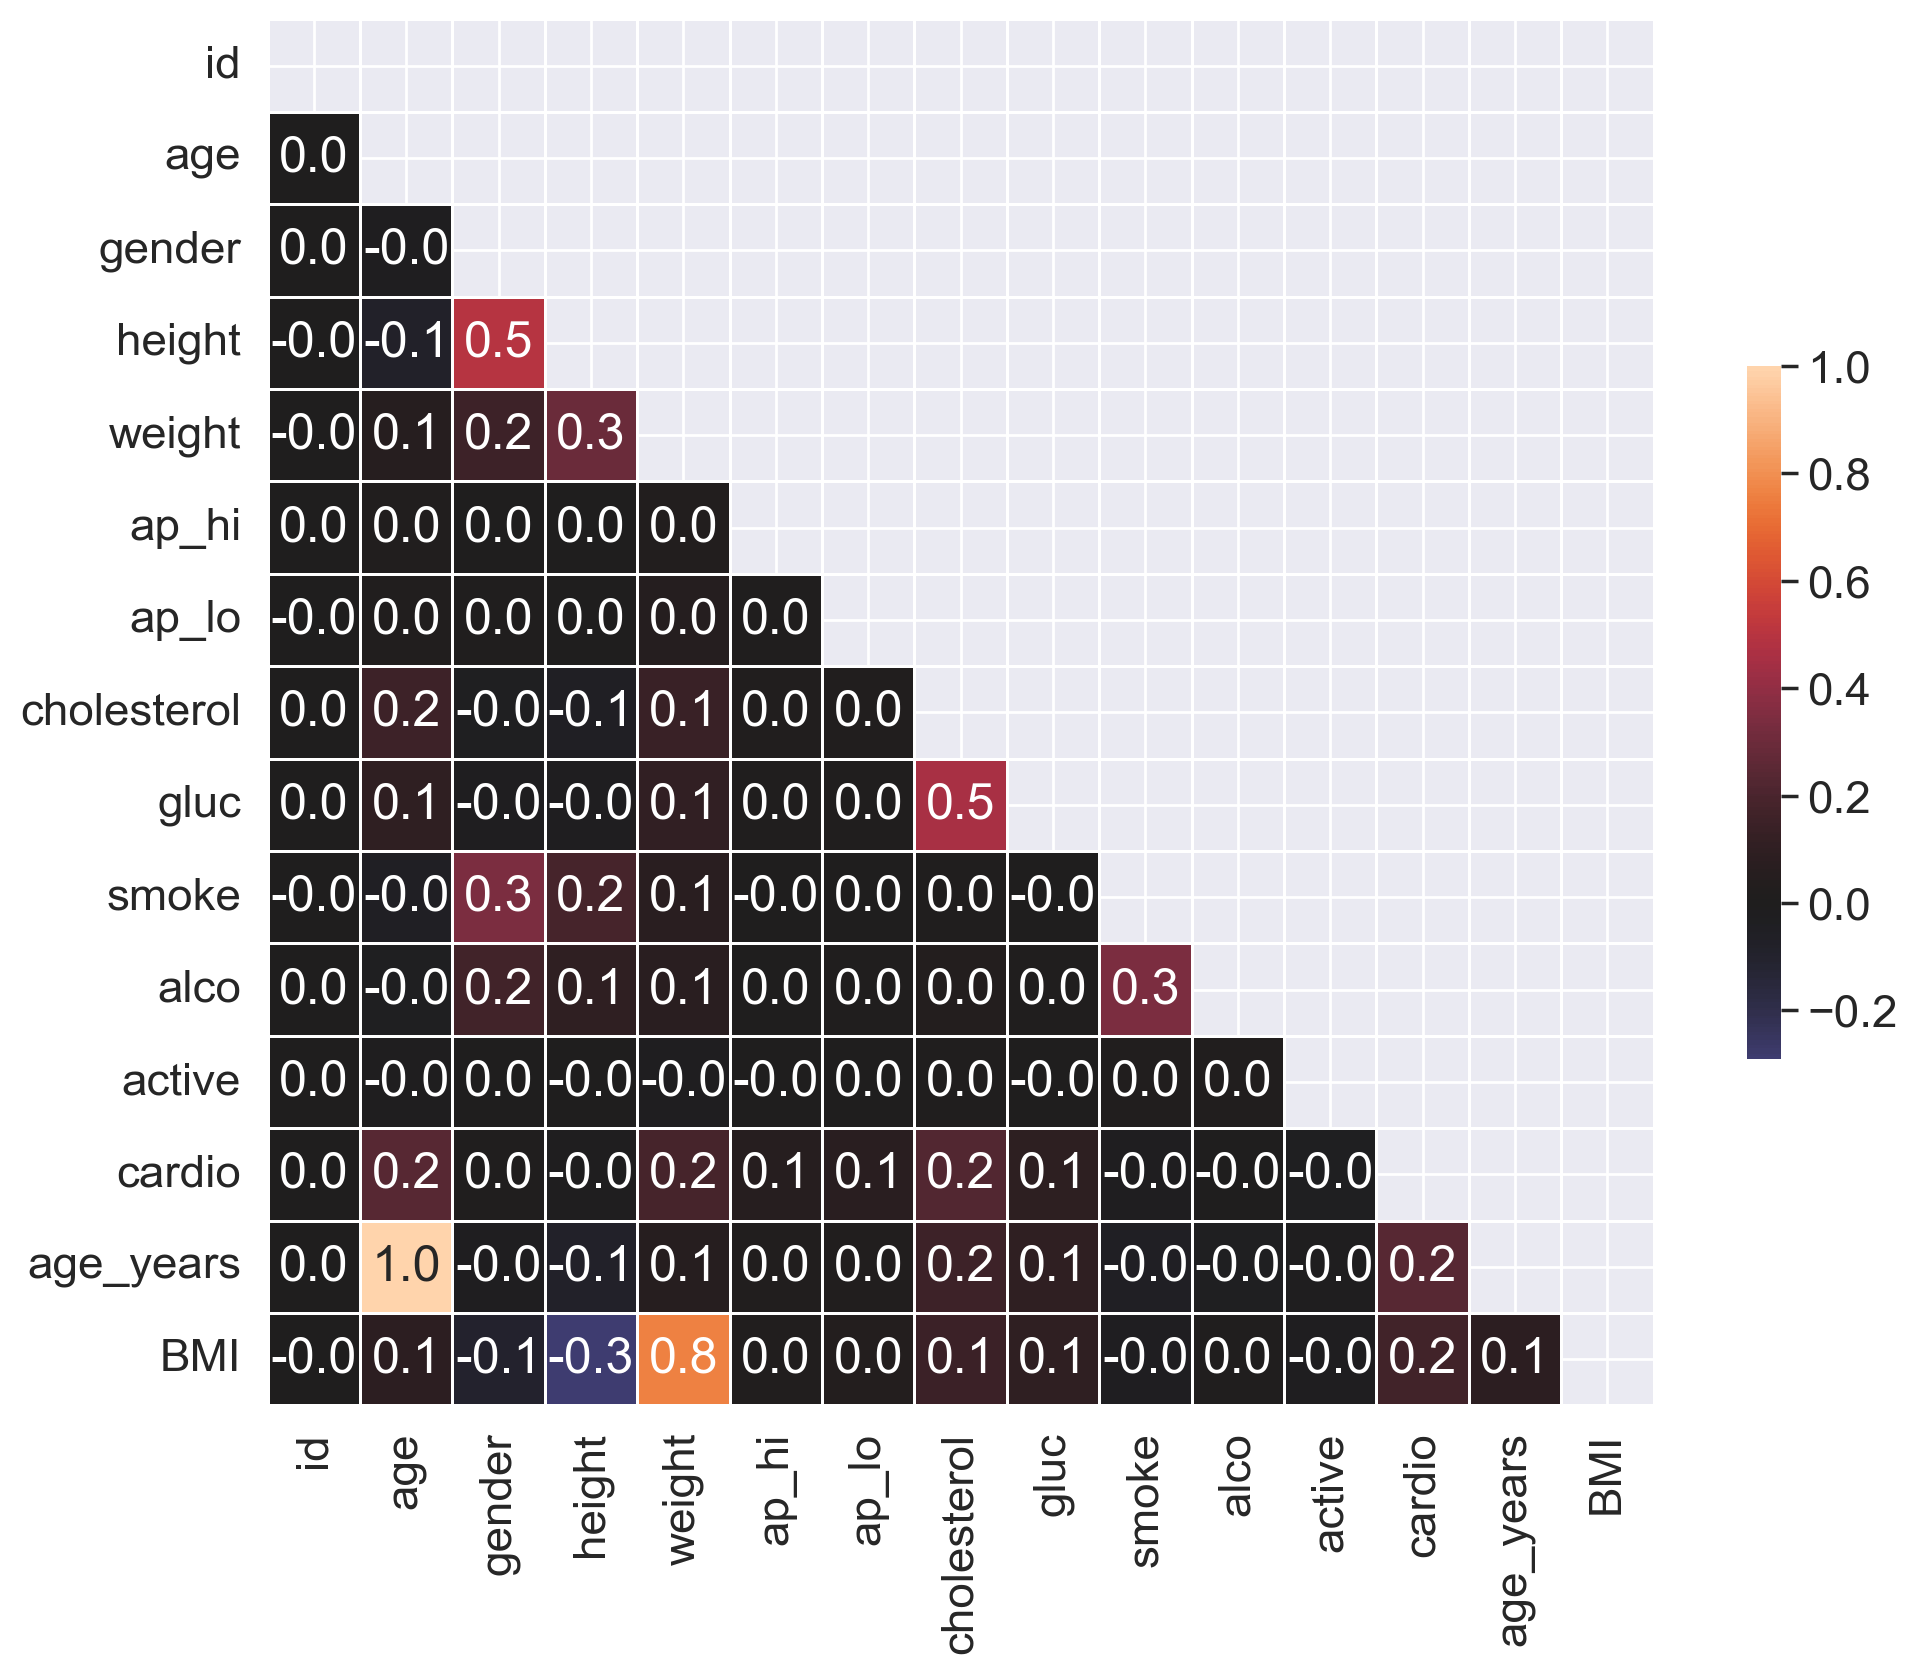

In [16]:
df = filtered_df.copy()

corr = df.corr(method="pearson")

mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(
    corr,
    mask=mask,
    vmax=1,
    center=0,
    annot=True,
    fmt=".1f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
);

#### 2.2. Height distribution of men and women

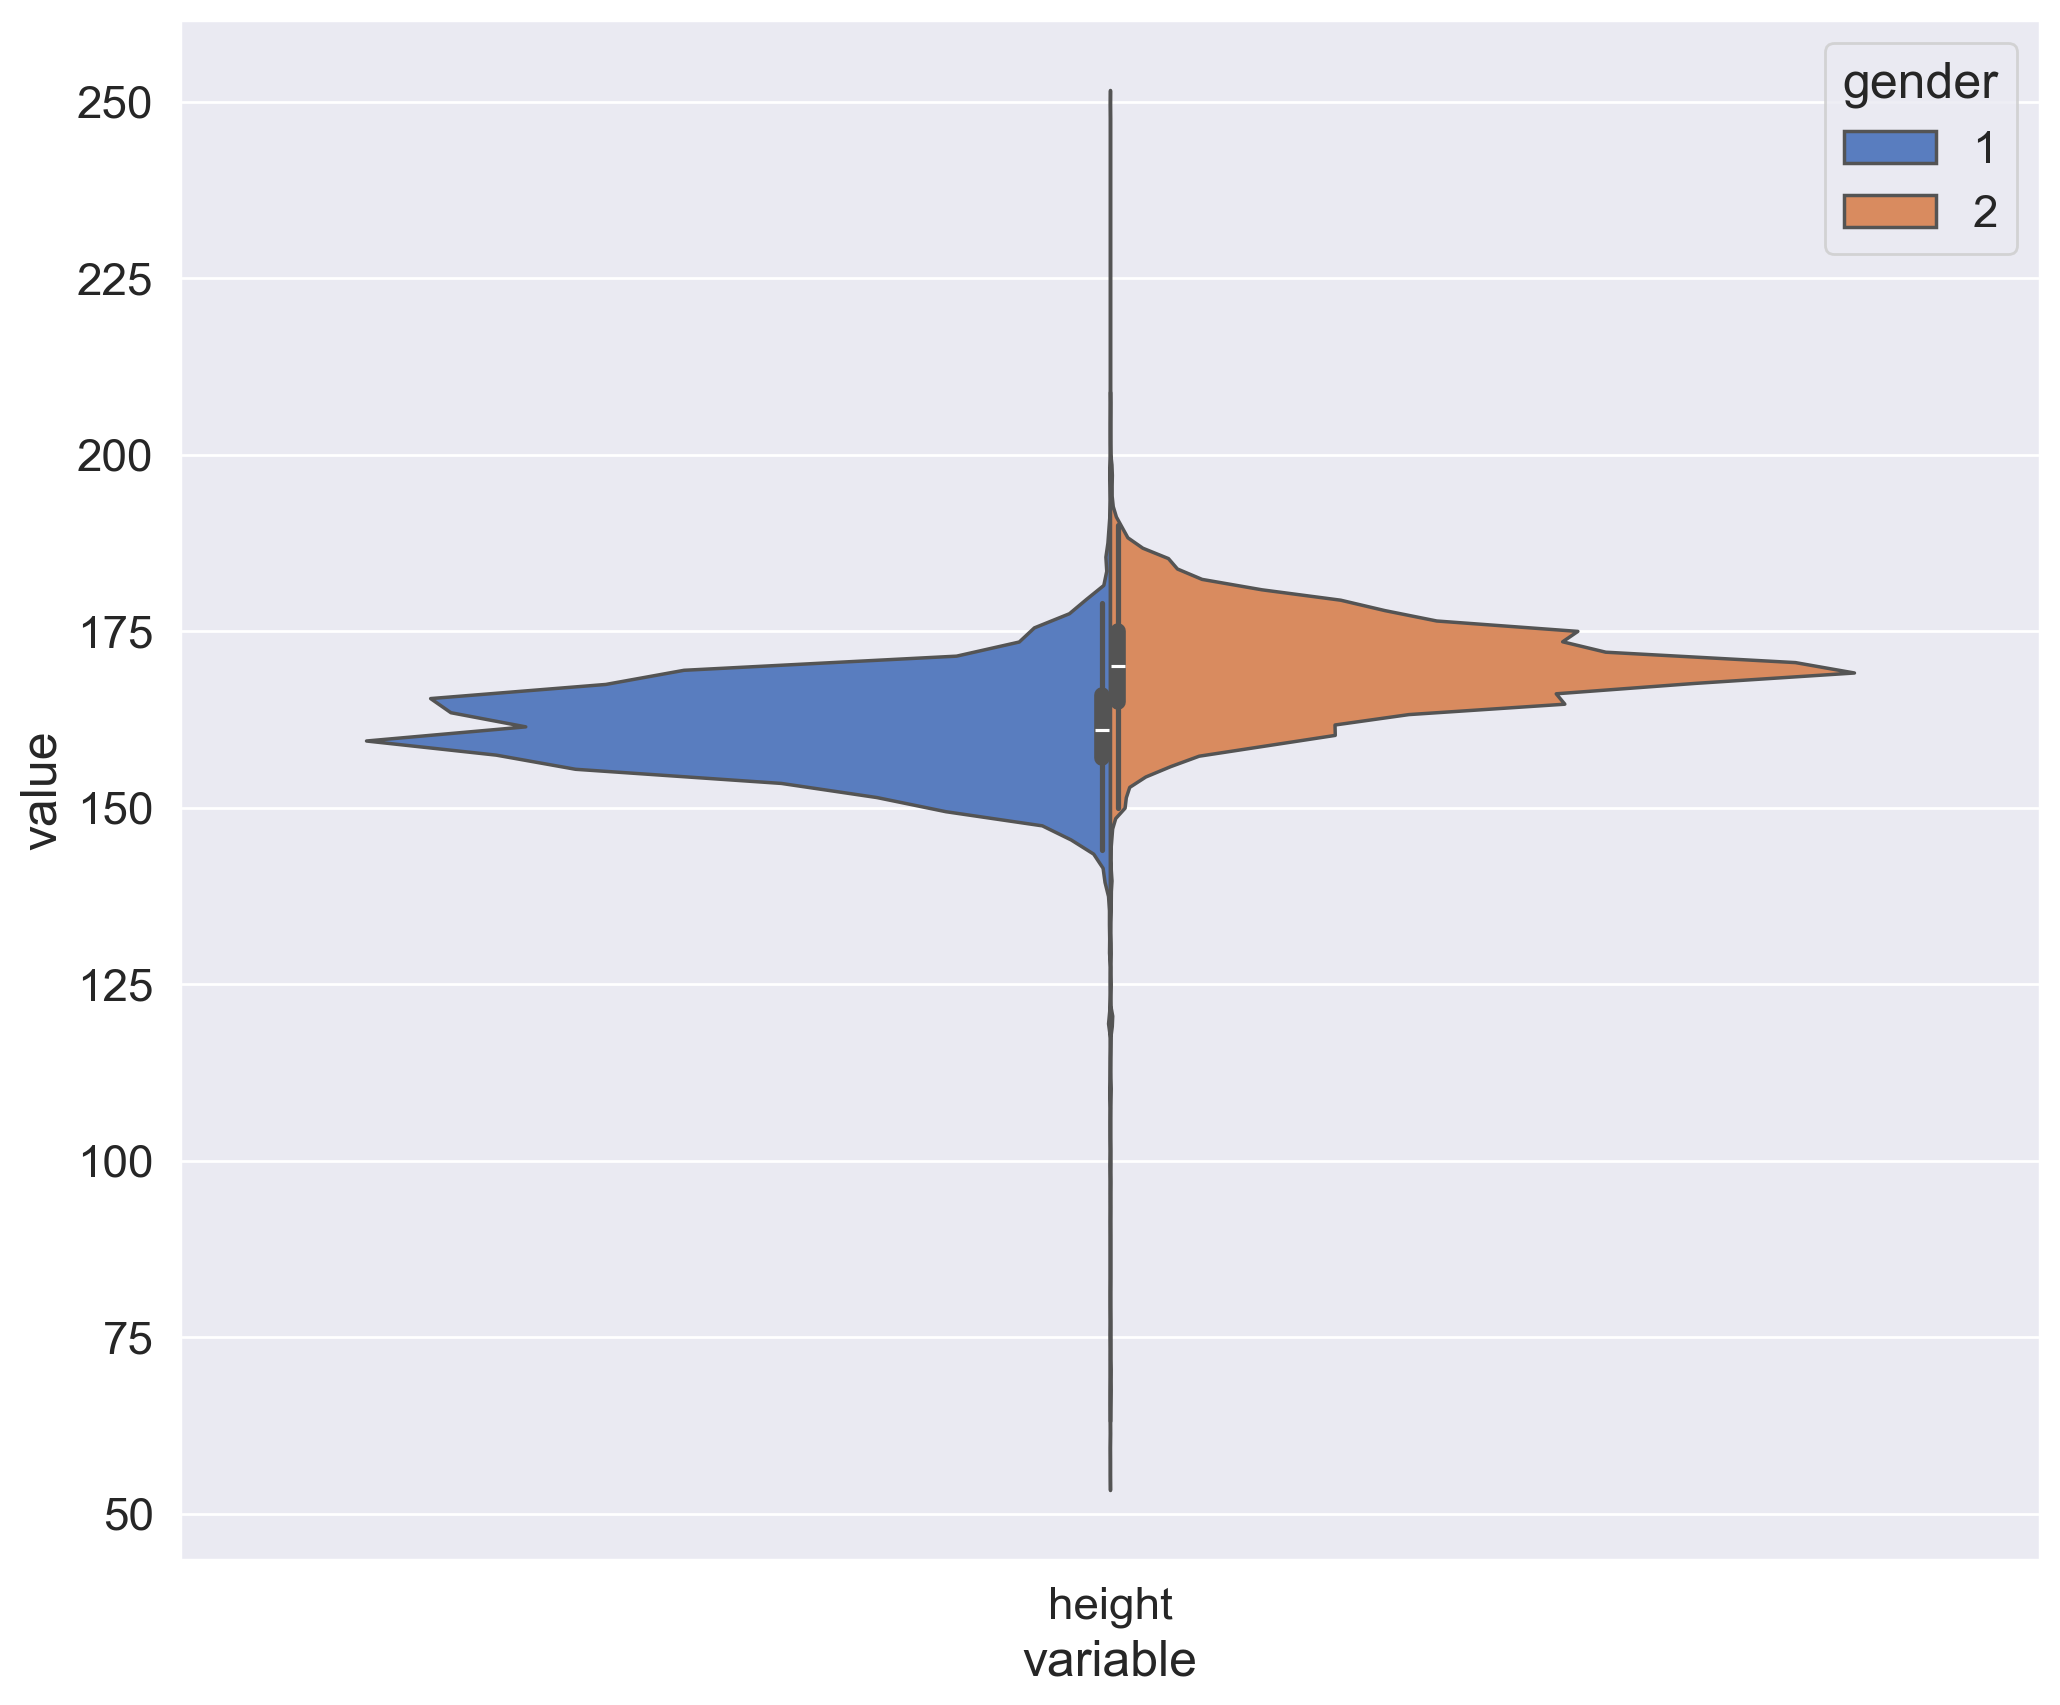

In [17]:
df_melt = pd.melt(frame=df, value_vars=["height"], id_vars=["gender"])

plt.figure(figsize=(12, 10))
ax = sns.violinplot(
    x="variable",
    y="value",
    hue="gender",
    palette="muted",
    split=True,
    data=df_melt,
    scale="count",
    scale_hue=False,
)

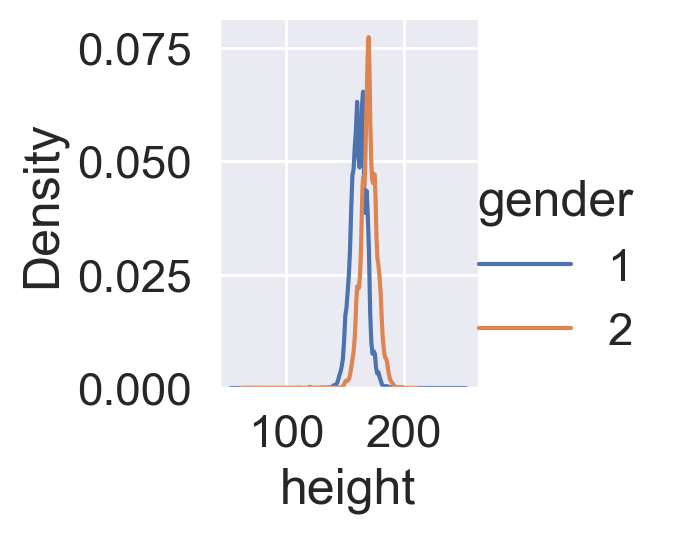

In [18]:
sns.FacetGrid(df, hue="gender").map(sns.kdeplot, "height").add_legend();

## 2.3. Rank correlation

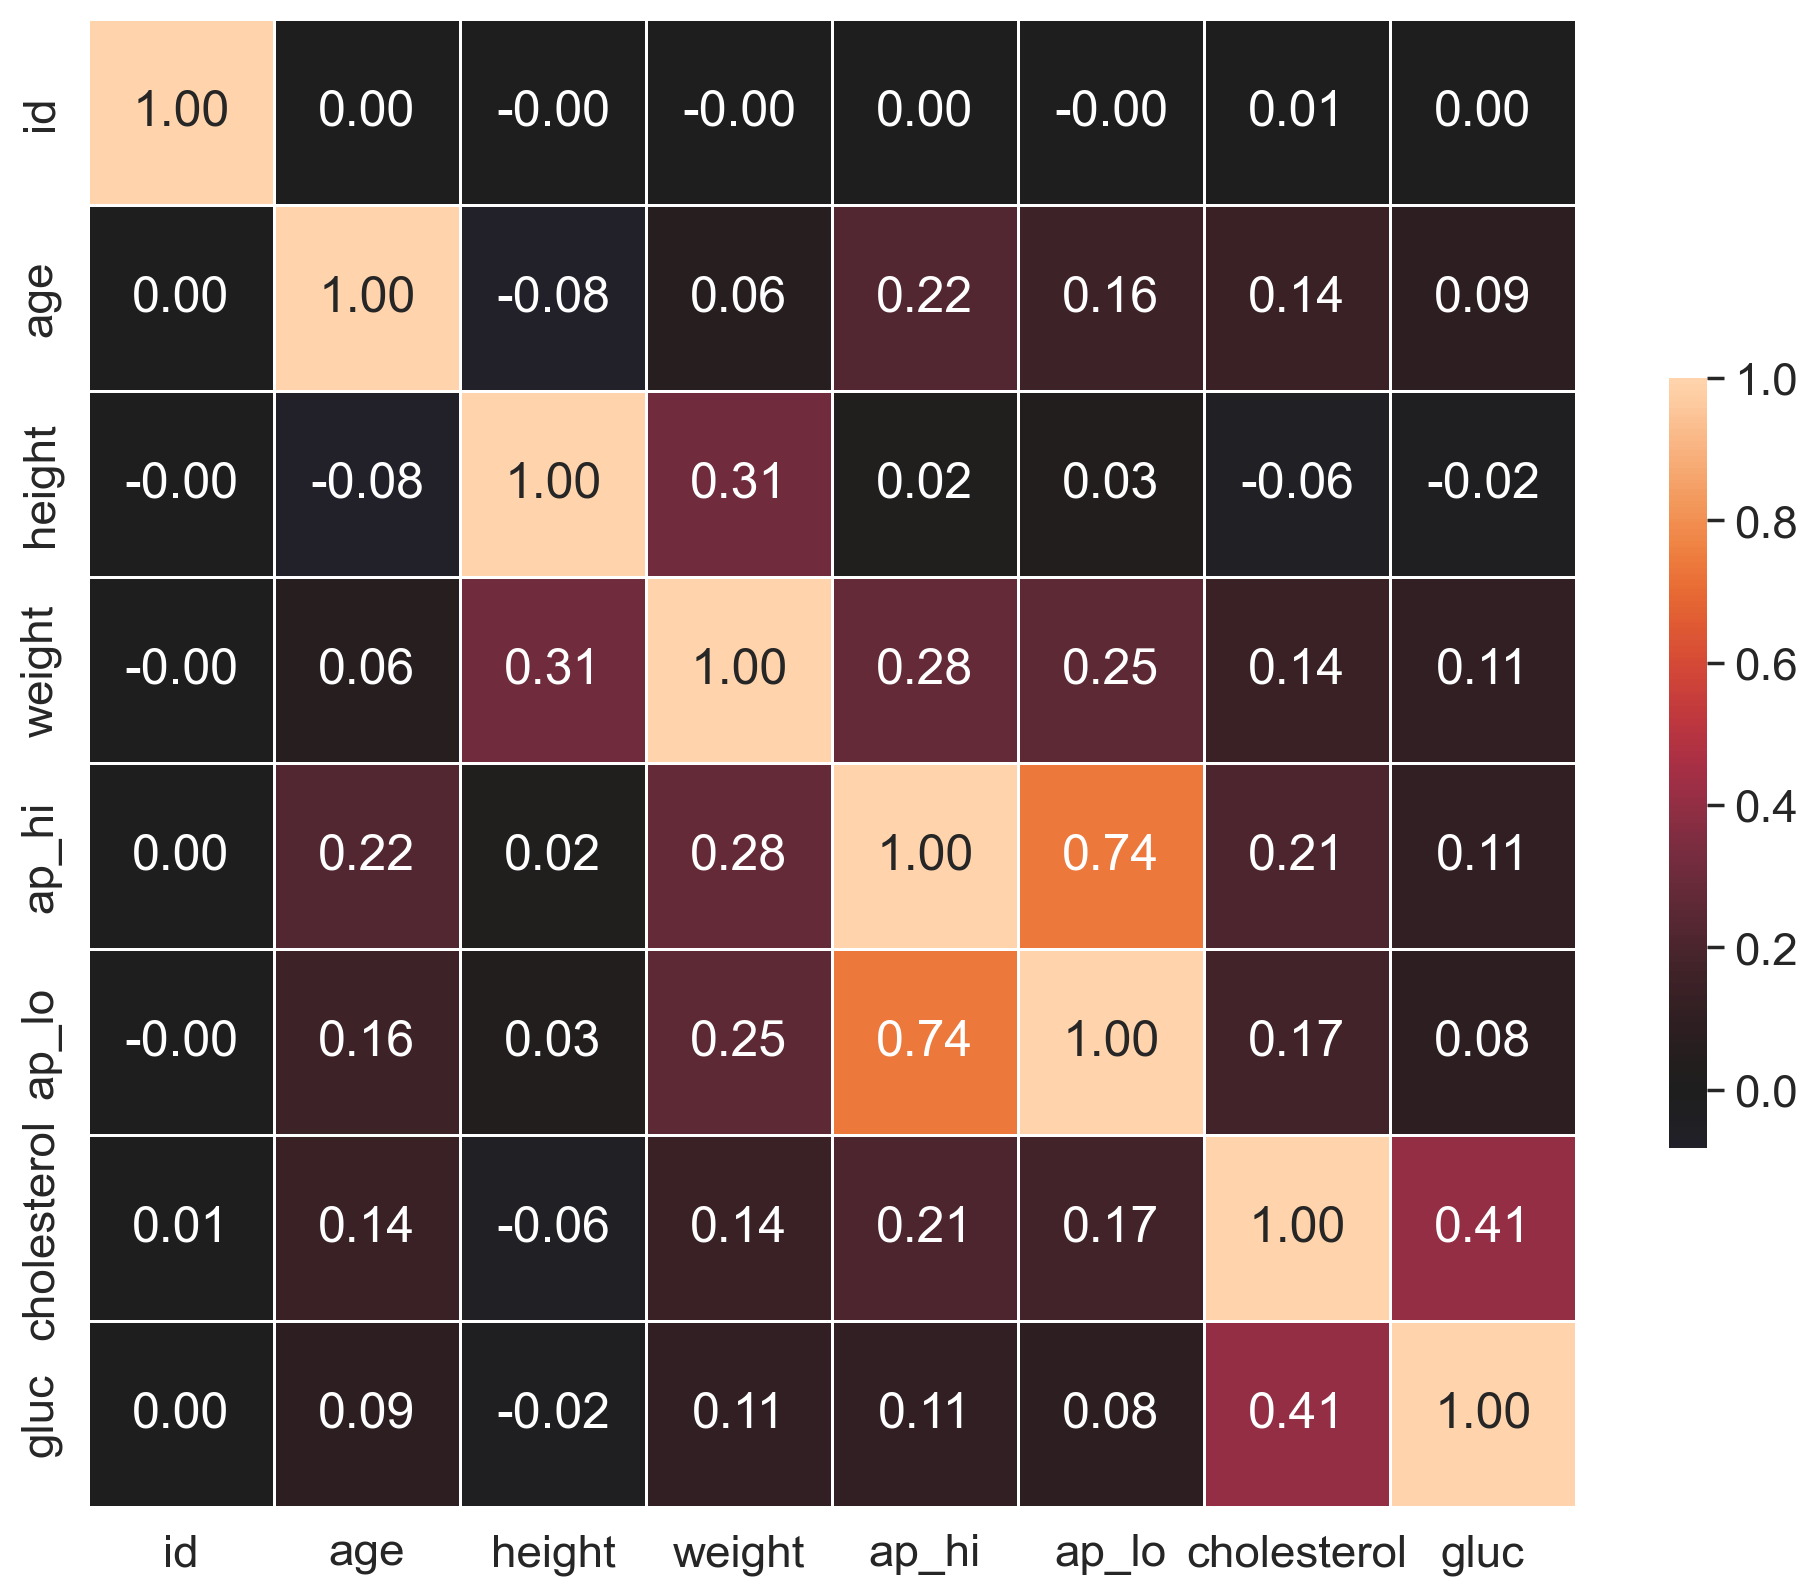

In [19]:
corr = df[
    ["id", "age", "height", "weight", "ap_hi", "ap_lo", "cholesterol", "gluc"]
].corr(method="spearman")

f, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(
    corr,
    vmax=1,
    center=0,
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
);

#### 2.4. Age

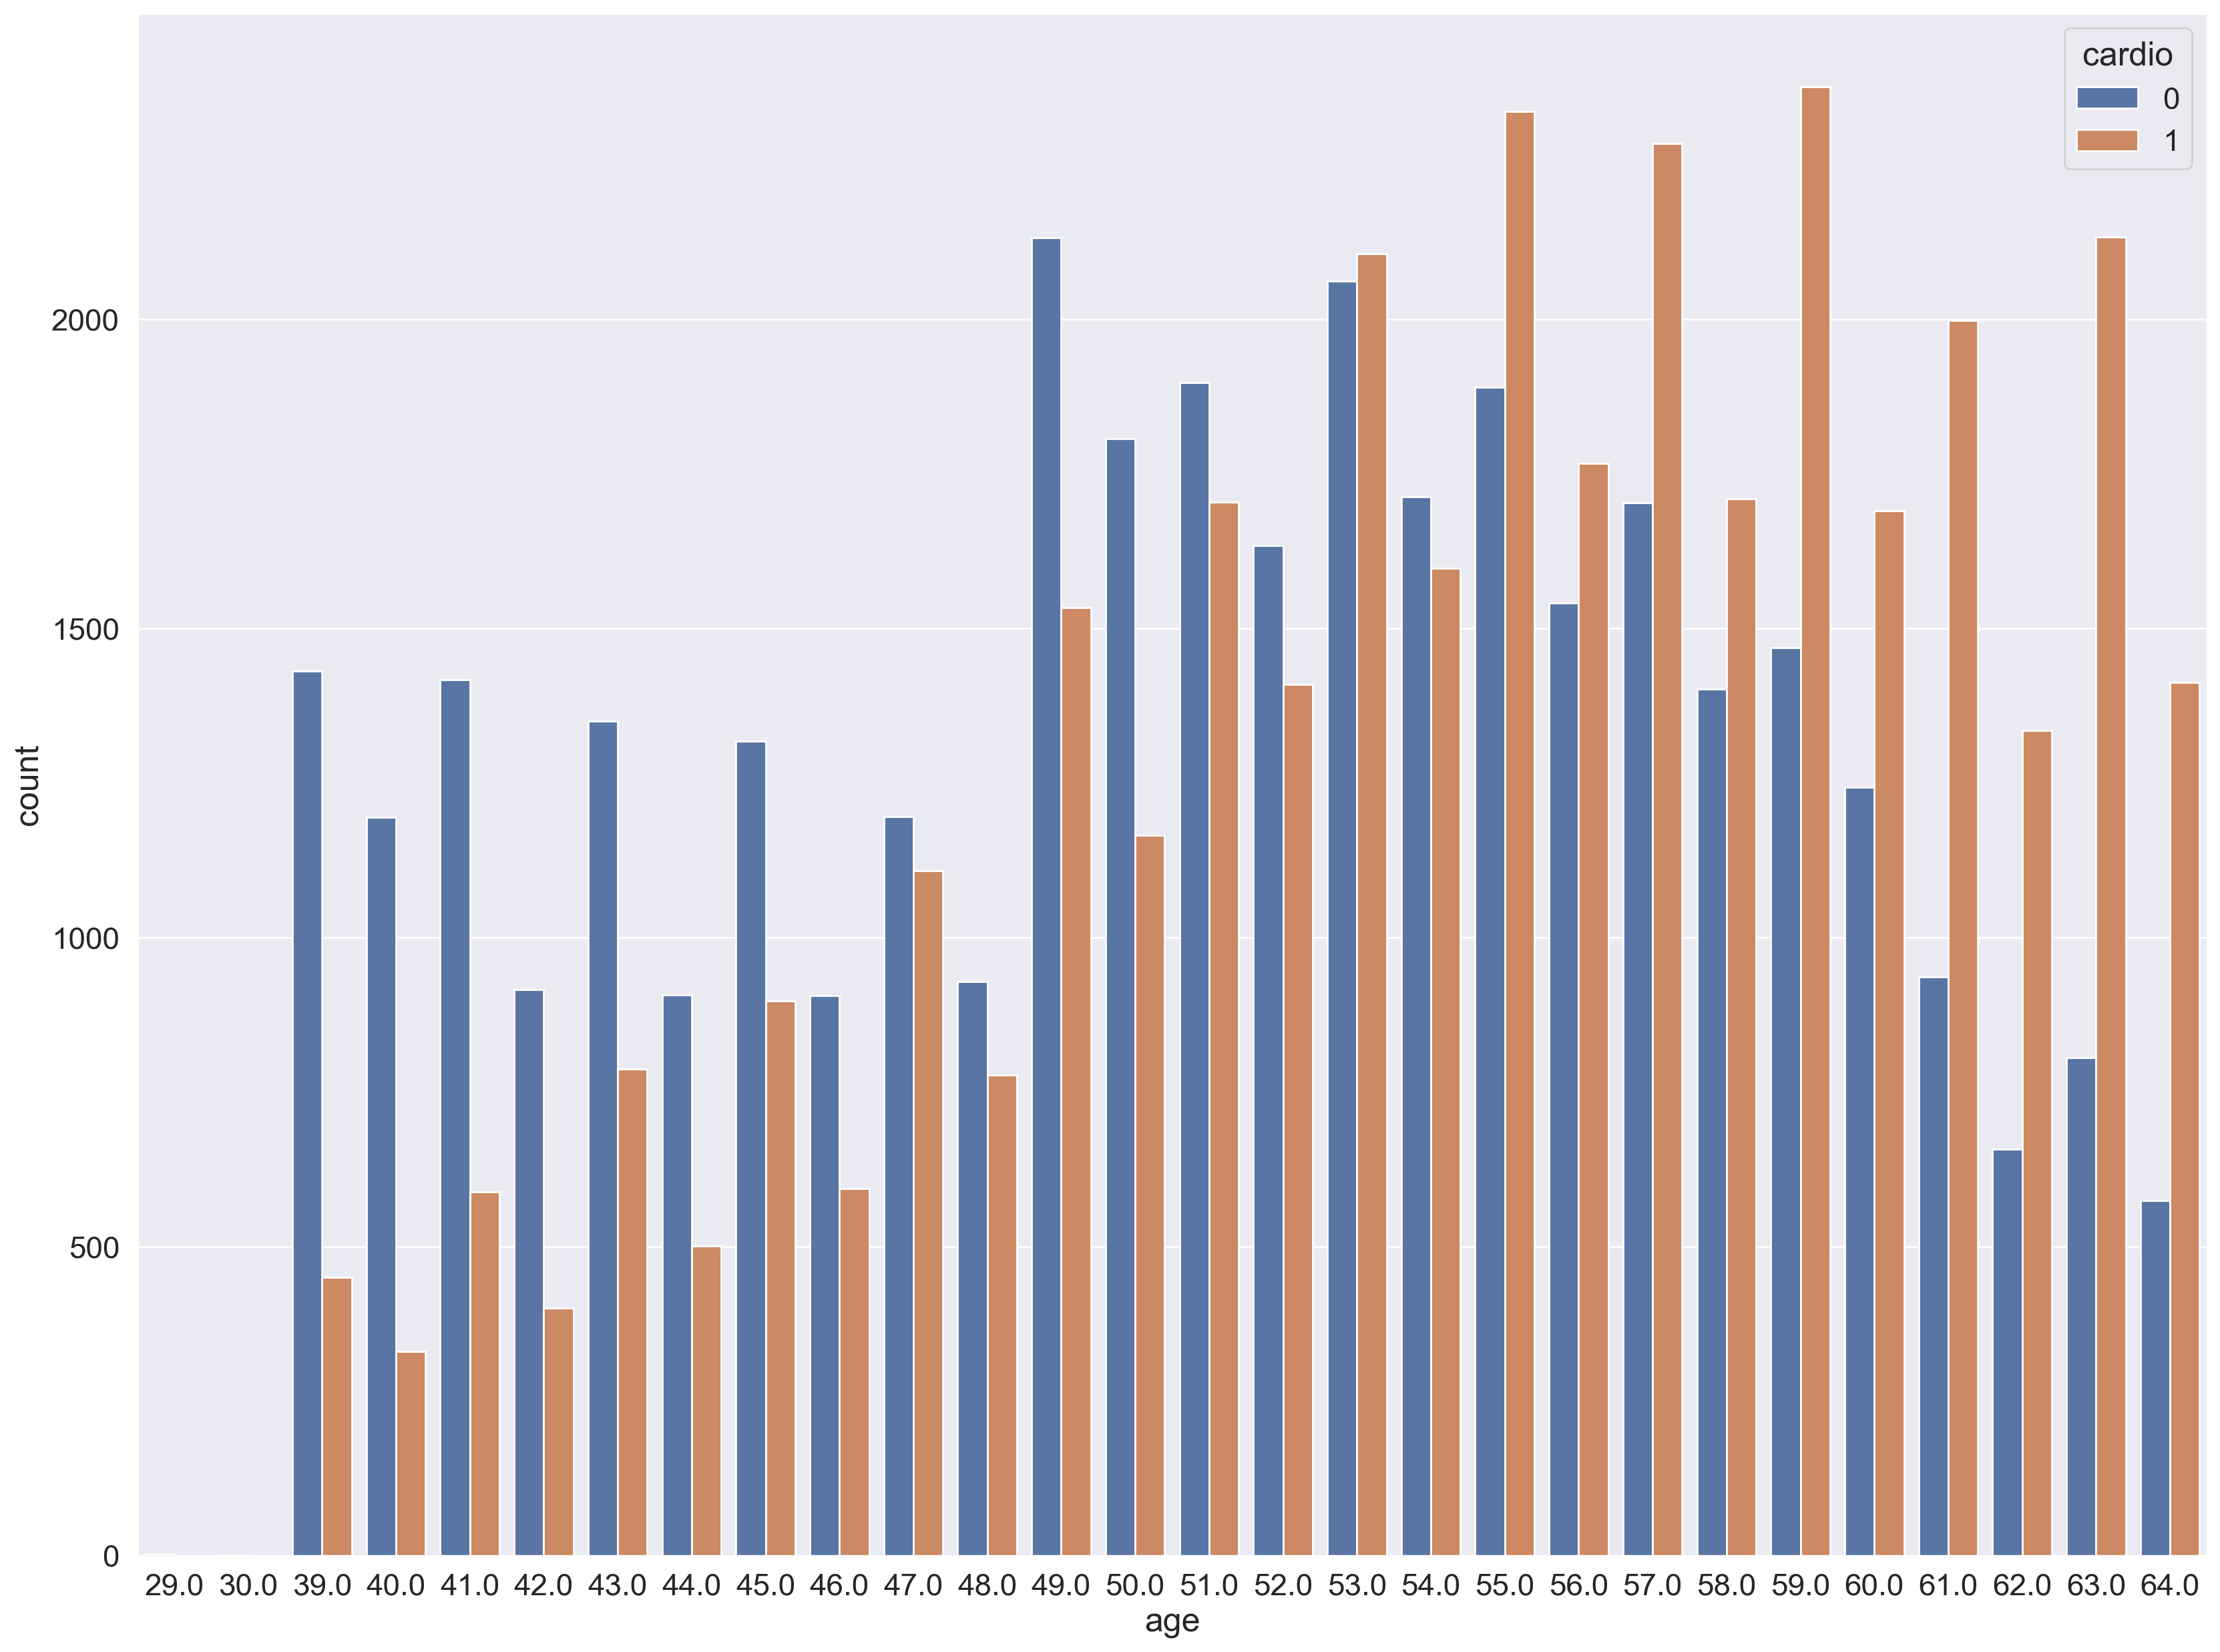

In [27]:
f, ax = plt.subplots(figsize=(20, 15))

ax = sns.countplot(x=df["age"] // 365.25, hue="cardio", data=df);